# Amazon Reviews Sentiment Analysis

### Libraries

In [83]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm


### Load the data


In [84]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("data/database.sqlite")
df = pd.read_sql_query("SELECT * from Reviews", con)


In [85]:
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [86]:
print ('Initial data:',df.shape)

# downsize data
df  = df.head(500)

Initial data: (568454, 10)


### Basic EDA

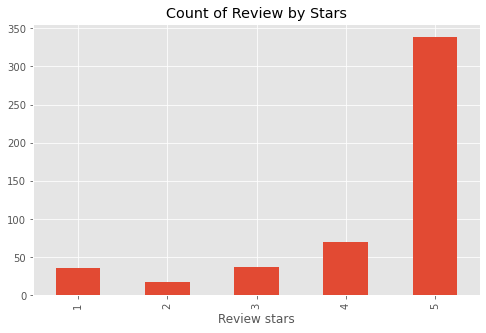

In [87]:
ax = df['Score'].value_counts().sort_index() \
     .plot(kind = 'bar', 
           title = 'Count of Review by Stars',
           figsize = (8,5))
ax.set_xlabel('Review stars')
plt.show()


### NLTK on example 

In [88]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [89]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [90]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [91]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER Sentiment Scoring 

In [92]:
sia = SentimentIntensityAnalyzer()

In [93]:
sia.polarity_scores(example)

{'neg': 0.21, 'neu': 0.79, 'pos': 0.0, 'compound': -0.5448}

### Apply VADER to Amazon Review Data

In [94]:
# Run polarity score on each row 
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

100%|██████████| 500/500 [00:00<00:00, 2716.86it/s]


In [95]:
vaders_results = pd.DataFrame(results).T
vaders_results = vaders_results.reset_index().rename(columns = {'index':'Id'} )
vaders_results = vaders_results.merge(df, how = 'left')


In [96]:
vaders_results.head(5)


,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.711,0.289,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.085,0.771,0.144,0.8138,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,0.932,0.068,0.4404,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.599,0.401,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


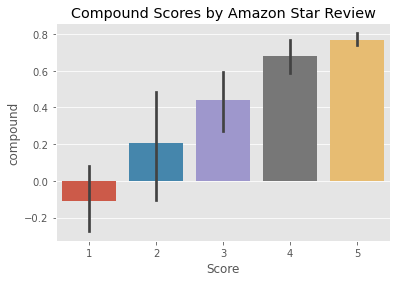

In [97]:
ax = sns.barplot(data = vaders_results, x = 'Score', y = 'compound')
ax.set_title('Compound Scores by Amazon Star Review')
plt.show()

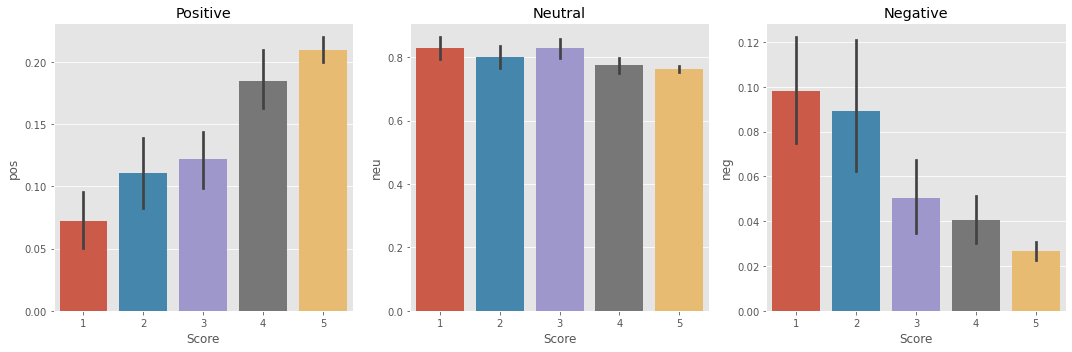

In [98]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data= vaders_results , x = 'Score', y = 'pos', ax = ax[0] )
sns.barplot(data= vaders_results , x = 'Score', y = 'neu', ax = ax[1] )
sns.barplot(data= vaders_results , x = 'Score', y = 'neg', ax = ax[2] )
ax[0].set_title('Positive')
ax[1].set_title('Neutral')
ax[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model (Transfer Learning)